## Fruit trait prediction from image inputs

* input is an image and outpur is a multi scalar regression vector for the predicted fruit traits
* these traits are measurements of the fruit

In [1]:

from fastai.vision.all import *


In [2]:

from fastcore.basics import Int
from fastcore.transform import DisplayedTransform
from fastcore.xtras import Path

from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import RandomSplitter, get_image_files, ColReader

from fastai.losses import MSELossFlat

from fastai.torch_core import ShowTitle, show_title, TitledFloat

from fastai.vision.augment import Resize, aug_transforms, Flip, Rotate, Zoom, Warp
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet50

from datetime import datetime, timedelta


import pandas as pd
from scipy.io import loadmat
import numpy as np

from scipy.io import loadmat
from datetime import datetime, timedelta

from fastai.metrics import mae, rmse, R2Score


In [3]:

n_out_val      = 12
img_resize_val = 150


In [4]:

path= 'fruits/'


In [5]:

AllData = pd.read_csv(path +'PhenotypeDataUGA.csv')


In [6]:

AllData


,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,147,6742,84.32,16.80,31.41,87.67,17.61,32.41,101.6,112.0,90.94,0.19,1.09,0.2
1,132,6744,75.96,18.63,25.27,82.09,19.57,26.66,118.3,122.7,73.39,0.18,0.93,0.2
2,20,6745,69.47,18.00,23.02,73.99,18.98,24.28,124.0,136.9,65.64,0.18,0.92,0.2
3,83,6746,74.58,14.73,27.44,80.63,15.52,28.92,108.6,101.7,63.50,0.18,0.81,0.2
4,119,6748,79.19,15.29,30.22,84.72,16.08,31.85,100.5,88.6,73.25,0.18,0.90,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,79.37,16.03,22.55,85.12,16.89,31.21,96.8,105.8,76.44,0.18,0.93,0.2
291,677,7722,54.35,15.63,16.64,58.76,16.44,17.33,144.5,139.6,48.75,0.21,0.87,0.2
292,1410,7723,49.77,14.02,15.43,57.10,14.79,16.22,138.5,143.7,37.69,0.20,0.69,0.2
293,1434,7727,67.71,18.25,22.06,73.26,19.23,23.25,145.2,126.5,69.12,0.20,0.98,0.2


We need to create a tuple is (x,y) for our model to train. 
So we'll create like this 

(image_id, [column names])

Let's create a new 
column combined which is a list of the dependent variables.

In [7]:

headers_list = AllData.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))




['line', 'photo_id', 'perimeter1_cm', 'width1_cm', 'heigth1_cm', 'perimeter2_cm', 'width2_cm', 'heigth2_cm', 'prox_angl_macr', 'distal_angl_macr', 'tomat_pericap_area', 'tomat_pericap_area_ratio', 'tomat_pericap_thick', 'tomat_pericap_thick_ratio']
14
(0, 'line')
(1, 'photo_id')
(2, 'perimeter1_cm')
(3, 'width1_cm')
(4, 'heigth1_cm')
(5, 'perimeter2_cm')
(6, 'width2_cm')
(7, 'heigth2_cm')
(8, 'prox_angl_macr')
(9, 'distal_angl_macr')
(10, 'tomat_pericap_area')
(11, 'tomat_pericap_area_ratio')
(12, 'tomat_pericap_thick')
(13, 'tomat_pericap_thick_ratio')


In [9]:

list_of_traits = [ 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
                  'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
                  'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]

AllData['combined'] = AllData[ list_of_traits ].values.tolist()


In [10]:

AllData


,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
0,147,6742,84.32,16.80,31.41,87.67,17.61,32.41,101.6,112.0,90.94,0.19,1.09,0.2,"[84.32, 16.8, 31.41, 87.67, 17.61, 32.41, 101.6, 112.0, 90.94, 0.19, 1.09, 0.2]"
1,132,6744,75.96,18.63,25.27,82.09,19.57,26.66,118.3,122.7,73.39,0.18,0.93,0.2,"[75.96, 18.63, 25.27, 82.09, 19.57, 26.66, 118.3, 122.7, 73.39, 0.18, 0.93, 0.2]"
2,20,6745,69.47,18.00,23.02,73.99,18.98,24.28,124.0,136.9,65.64,0.18,0.92,0.2,"[69.47, 18.0, 23.02, 73.99, 18.98, 24.28, 124.0, 136.9, 65.64, 0.18, 0.92, 0.2]"
3,83,6746,74.58,14.73,27.44,80.63,15.52,28.92,108.6,101.7,63.50,0.18,0.81,0.2,"[74.58, 14.73, 27.44, 80.63, 15.52, 28.92, 108.6, 101.7, 63.5, 0.18, 0.81, 0.2]"
4,119,6748,79.19,15.29,30.22,84.72,16.08,31.85,100.5,88.6,73.25,0.18,0.90,0.2,"[79.19, 15.29, 30.22, 84.72, 16.08, 31.85, 100.5, 88.6, 73.25, 0.18, 0.9, 0.2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,79.37,16.03,22.55,85.12,16.89,31.21,96.8,105.8,76.44,0.18,0.93,0.2,"[79.37, 16.03, 22.55, 85.12, 16.89, 31.21, 96.8, 105.8, 76.44, 0.18, 0.93, 0.2]"
291,677,7722,54.35,15.63,16.64,58.76,16.44,17.33,144.5,139.6,48.75,0.21,0.87,0.2,"[54.35, 15.63, 16.64, 58.76, 16.44, 17.33, 144.5, 139.6, 48.75, 0.21, 0.87, 0.2]"
292,1410,7723,49.77,14.02,15.43,57.10,14.79,16.22,138.5,143.7,37.69,0.20,0.69,0.2,"[49.77, 14.02, 15.43, 57.1, 14.79, 16.22, 138.5, 143.7, 37.69, 0.2, 0.69, 0.2]"
293,1434,7727,67.71,18.25,22.06,73.26,19.23,23.25,145.2,126.5,69.12,0.20,0.98,0.2,"[67.71, 18.25, 22.06, 73.26, 19.23, 23.25, 145.2, 126.5, 69.12, 0.2, 0.98, 0.2]"


## Split data train and test

In [17]:

msk = np.random.rand(  len(AllData)  ) < 0.7

train = AllData[msk]

test  = AllData[~msk]



In [18]:

print(  len(test)  )

print(  len(train) )


93
202


In [19]:
train

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
1,132,6744,75.96,18.63,25.27,82.09,19.57,26.66,118.3,122.7,73.39,0.18,0.93,0.2,"[75.96, 18.63, 25.27, 82.09, 19.57, 26.66, 118.3, 122.7, 73.39, 0.18, 0.93, 0.2]"
2,20,6745,69.47,18.00,23.02,73.99,18.98,24.28,124.0,136.9,65.64,0.18,0.92,0.2,"[69.47, 18.0, 23.02, 73.99, 18.98, 24.28, 124.0, 136.9, 65.64, 0.18, 0.92, 0.2]"
3,83,6746,74.58,14.73,27.44,80.63,15.52,28.92,108.6,101.7,63.50,0.18,0.81,0.2,"[74.58, 14.73, 27.44, 80.63, 15.52, 28.92, 108.6, 101.7, 63.5, 0.18, 0.81, 0.2]"
5,475,6752,54.12,11.96,19.26,62.29,12.39,20.29,97.3,115.0,35.78,0.18,0.60,0.2,"[54.12, 11.96, 19.26, 62.29, 12.39, 20.29, 97.3, 115.0, 35.78, 0.18, 0.6, 0.2]"
6,304,6753,74.15,19.10,24.71,79.59,20.01,26.01,124.6,126.6,50.82,0.12,0.66,0.2,"[74.15, 19.1, 24.71, 79.59, 20.01, 26.01, 124.6, 126.6, 50.82, 0.12, 0.66, 0.2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,114,7694,94.15,27.19,28.33,99.33,28.64,29.84,156.8,135.7,158.95,0.23,1.68,0.2,"[94.15, 27.19, 28.33, 99.33, 28.64, 29.84, 156.8, 135.7, 158.95, 0.23, 1.68, 0.2]"
289,1038,7704,57.16,11.95,21.04,67.82,12.53,22.55,102.9,98.1,44.15,0.20,0.68,0.2,"[57.16, 11.95, 21.04, 67.82, 12.53, 22.55, 102.9, 98.1, 44.15, 0.2, 0.68, 0.2]"
290,453,7714,79.37,16.03,22.55,85.12,16.89,31.21,96.8,105.8,76.44,0.18,0.93,0.2,"[79.37, 16.03, 22.55, 85.12, 16.89, 31.21, 96.8, 105.8, 76.44, 0.18, 0.93, 0.2]"
291,677,7722,54.35,15.63,16.64,58.76,16.44,17.33,144.5,139.6,48.75,0.21,0.87,0.2,"[54.35, 15.63, 16.64, 58.76, 16.44, 17.33, 144.5, 139.6, 48.75, 0.21, 0.87, 0.2]"


In [20]:
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
0,147,6742,84.32,16.80,31.41,87.67,17.61,32.41,101.6,112.0,90.94,0.19,1.09,0.2,"[84.32, 16.8, 31.41, 87.67, 17.61, 32.41, 101.6, 112.0, 90.94, 0.19, 1.09, 0.2]"
4,119,6748,79.19,15.29,30.22,84.72,16.08,31.85,100.5,88.6,73.25,0.18,0.90,0.2,"[79.19, 15.29, 30.22, 84.72, 16.08, 31.85, 100.5, 88.6, 73.25, 0.18, 0.9, 0.2]"
8,150,6757,66.93,18.04,21.56,70.45,18.95,22.80,115.4,133.0,66.58,0.20,0.99,0.2,"[66.93, 18.04, 21.56, 70.45, 18.95, 22.8, 115.4, 133.0, 66.58, 0.2, 0.99, 0.2]"
9,154,6760,94.21,20.00,33.33,98.04,21.10,35.11,107.0,109.1,39.03,0.06,0.40,0.2,"[94.21, 20.0, 33.33, 98.04, 21.1, 35.11, 107.0, 109.1, 39.03, 0.06, 0.4, 0.2]"
13,440,6765,87.99,20.06,31.75,92.94,21.10,33.44,114.2,99.2,126.21,0.23,1.43,0.2,"[87.99, 20.06, 31.75, 92.94, 21.1, 33.44, 114.2, 99.2, 126.21, 0.23, 1.43, 0.2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,982,7442,63.63,13.97,23.15,69.71,14.68,24.51,101.3,103.6,45.69,0.16,0.68,0.2,"[63.63, 13.97, 23.15, 69.71, 14.68, 24.51, 101.3, 103.6, 45.69, 0.16, 0.68, 0.2]"
279,744,7443,81.37,21.99,25.40,85.85,23.17,26.57,147.1,146.4,80.57,0.16,0.97,0.2,"[81.37, 21.99, 25.4, 85.85, 23.17, 26.57, 147.1, 146.4, 80.57, 0.16, 0.97, 0.2]"
287,1071,7458,58.14,15.71,17.80,60.90,16.52,18.53,109.7,145.3,44.26,0.18,0.76,0.2,"[58.14, 15.71, 17.8, 60.9, 16.52, 18.53, 109.7, 145.3, 44.26, 0.18, 0.76, 0.2]"
292,1410,7723,49.77,14.02,15.43,57.10,14.79,16.22,138.5,143.7,37.69,0.20,0.69,0.2,"[49.77, 14.02, 15.43, 57.1, 14.79, 16.22, 138.5, 143.7, 37.69, 0.2, 0.69, 0.2]"


## Transforms and DataLoaders

In [24]:

class TitledList(list, ShowTitle):
    _show_args = {'label': 'text'}
    
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(self, ctx=ctx, **merge(self._show_args, kwargs))


In [34]:

## "Transform to int tensor"
## order = 10 # Need to run after PIL transforms on the GPU


class ToListTensor(DisplayedTransform):
    _show_args = {'label': 'text'}
    
    def __init__(self, split_idx=None,):
        super().__init__(split_idx=split_idx)

    def encodes(self, o): return o
    
    def decodes(self, o): return TitledList(o)


In [35]:

blocks = [ ImageBlock, RegressionBlock(n_out=n_out_val)  ]


In [36]:

item_tfms = [  Resize(img_resize_val)  ];    

batch_tfms = [  *aug_transforms( flip_vert=True, size=(img_resize_val) ), 
                Normalize.from_stats(  *imagenet_stats   )
]

splitter = RandomSplitter()


In [37]:

plant = DataBlock(blocks = blocks,
                  get_x = ColReader('photo_id', pref=f'fruits/images/IMG_', suff='.JPG'),
                  get_y = Pipeline( [ColReader('combined'), ToListTensor ]),
                  splitter = splitter,
                  item_tfms= item_tfms,
                  batch_tfms = batch_tfms,
                  n_inp = 1
)


In [31]:

dls = plant.dataloaders(train)


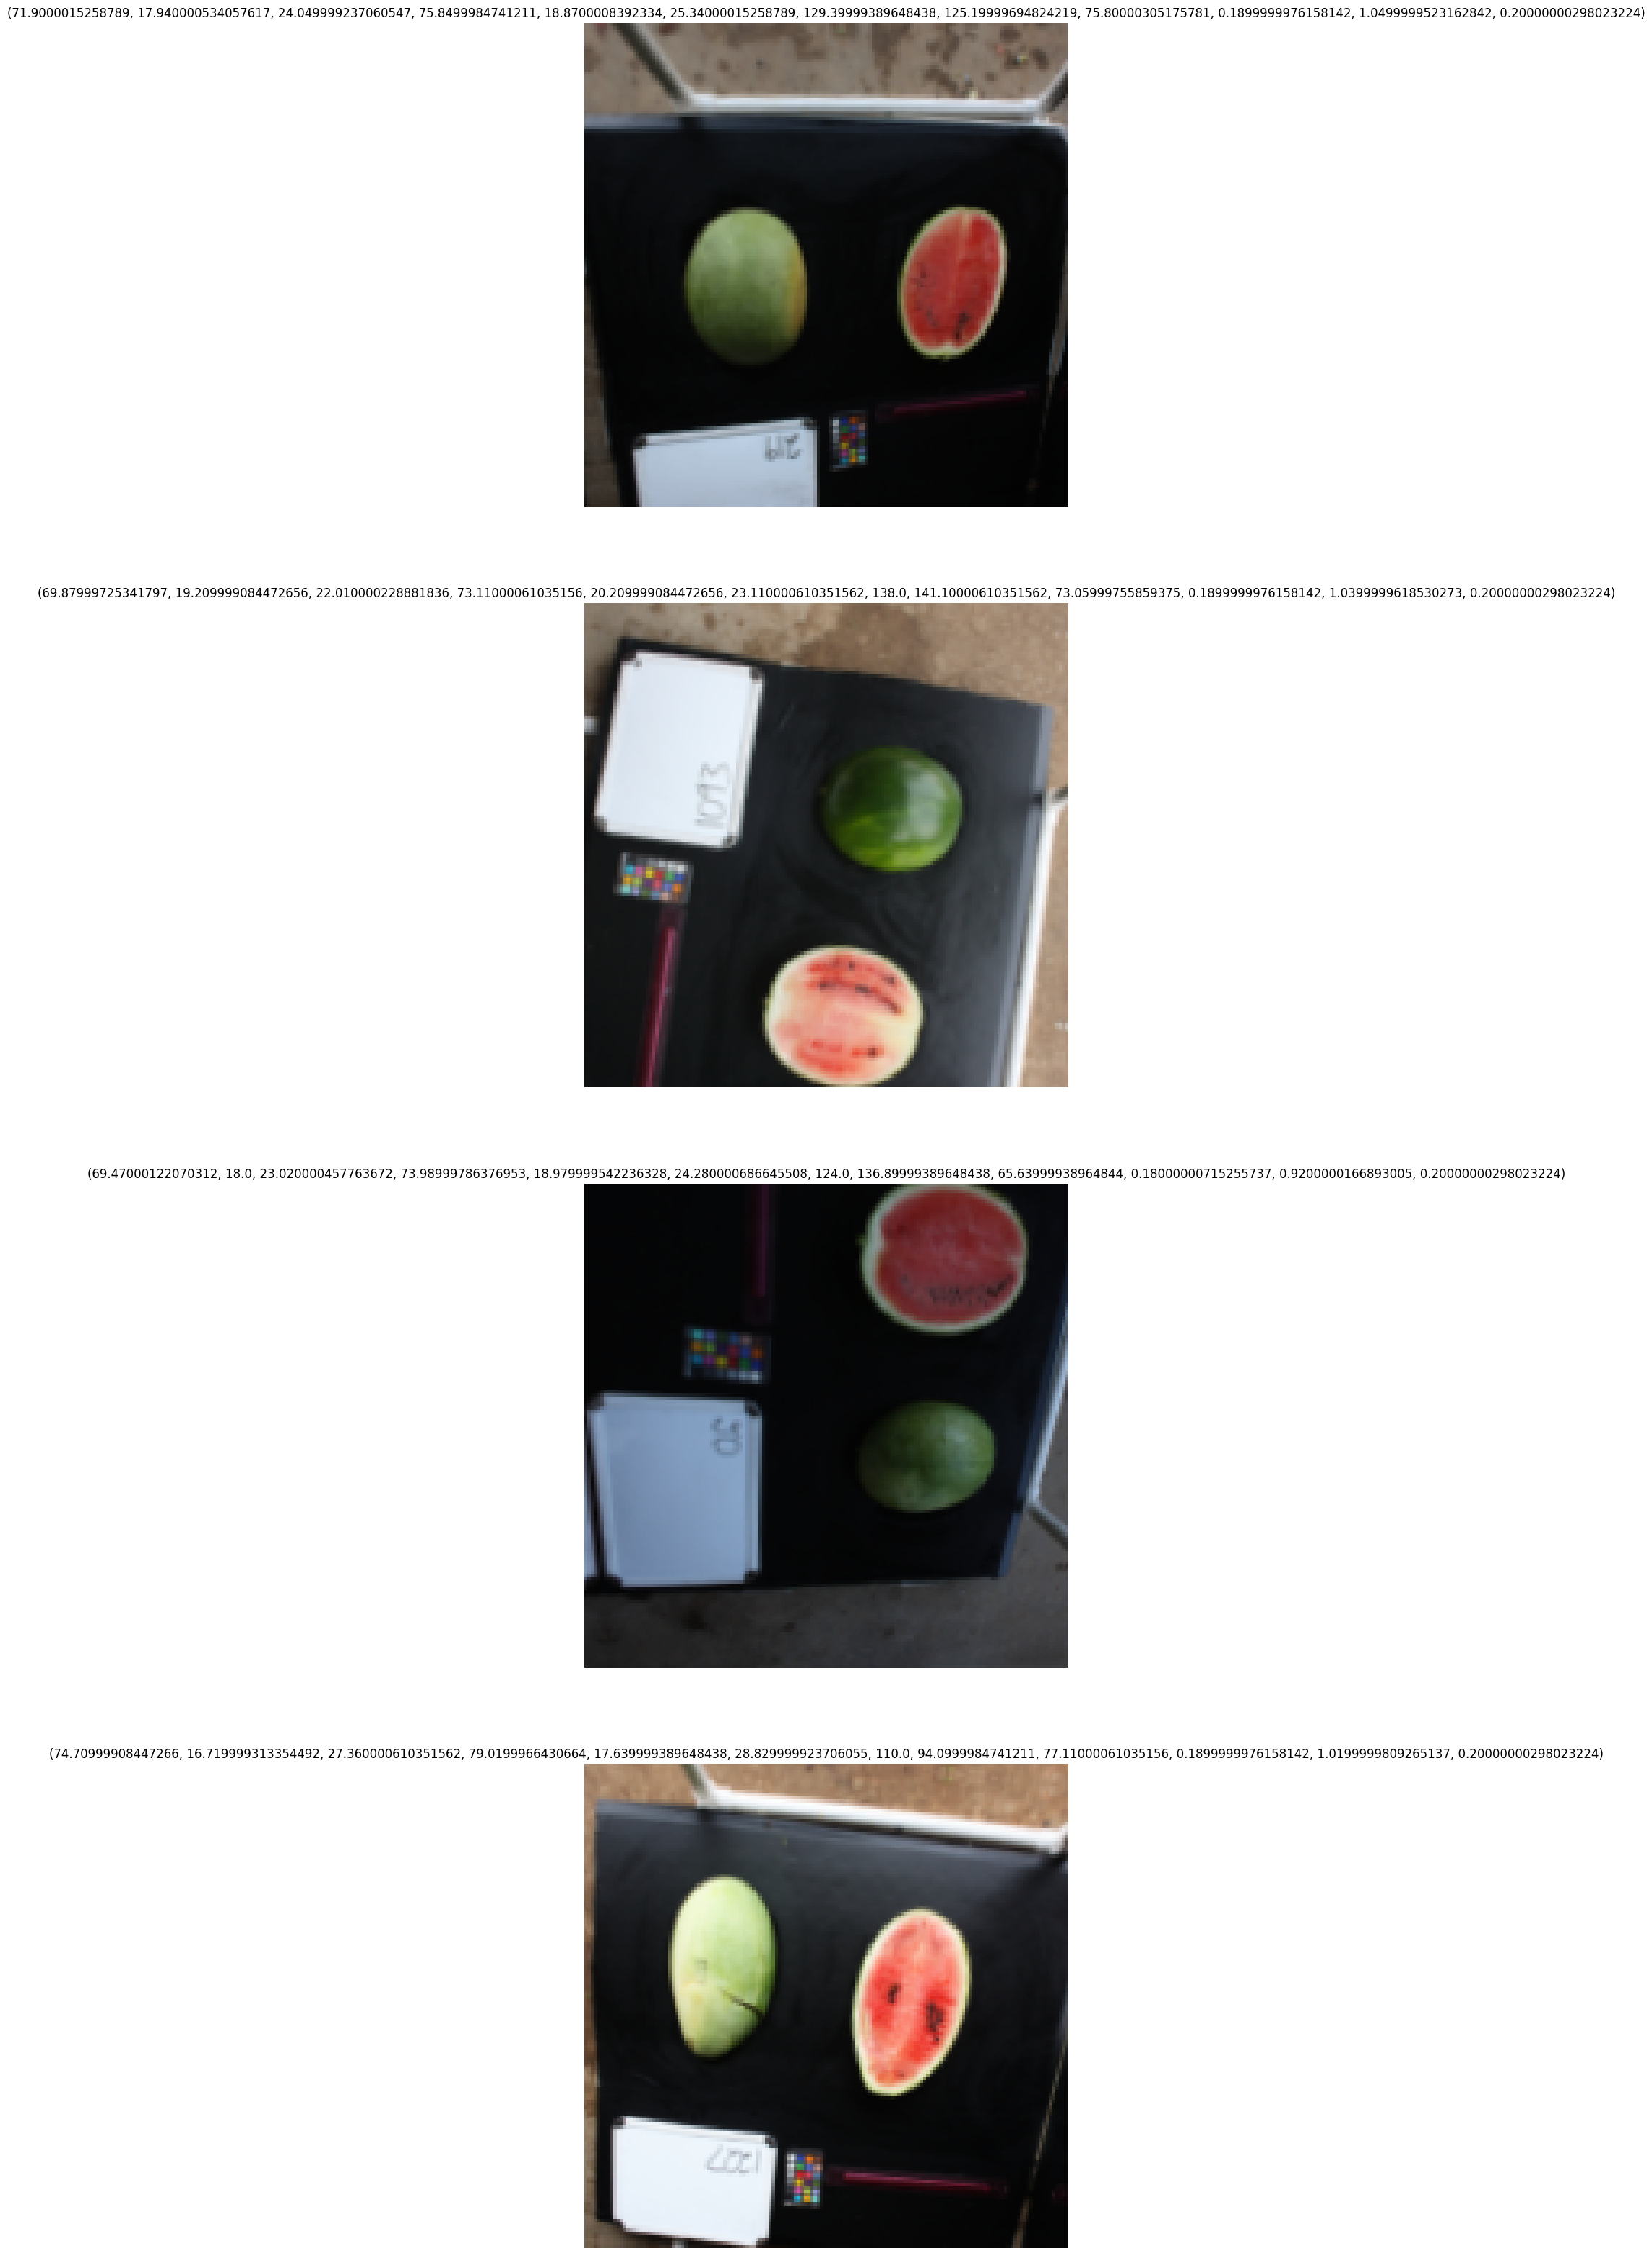

In [39]:

dls.show_batch(nrows=4, ncols=1, figsize=(40,40))


In [40]:

plant.summary(train)


Setting-up type transforms pipelines
1     132      6744          75.96      18.63       25.27          82.09   
2      20      6745          69.47      18.00       23.02          73.99   
3      83      6746          74.58      14.73       27.44          80.63   
5     475      6752          54.12      11.96       19.26          62.29   
6     304      6753          74.15      19.10       24.71          79.59   
..    ...       ...            ...        ...         ...            ...   
288   114      7694          94.15      27.19       28.33          99.33   
289  1038      7704          57.16      11.95       21.04          67.82   
290   453      7714          79.37      16.03       22.55          85.12   
291   677      7722          54.35      15.63       16.64          58.76   
293  1434      7727          67.71      18.25       22.06          73.26   

     width2_cm  heigth2_cm  prox_angl_macr  distal_angl_macr  \
1        19.57       26.66           118.3             122.7  

Setting up Pipeline: ColReader -- {'cols': 'combined', 'pref': '', 'suff': '', 'label_delim': None} -> ToListTensor -- {} -> RegressionSetup -- {'c': 12}
Setting up after_item: Pipeline: Resize -- {'size': (150, 150), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Dihedral -- {'size': 150, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -- {'size': (150, 150), 'method': 'crop', 'pad_mode':

In [41]:

dls.c = n_out_val



In [42]:

dls.c


12

## Training

In [48]:

model = resnet18


In [49]:

learn = cnn_learner(
               dls, 
               model, 
               metrics = [ MSELossFlat(), mae, rmse, R2Score() ], 
               loss_func = L1LossFlat(),
               y_range=(0,1),
)


In [50]:

learn.fine_tune(3)


epoch,train_loss,valid_loss,None,mae,_rmse,r2_score,time
0,47.198650,47.977055,4433.385254,47.977055,66.583672,-1.073543,00:42


epoch,train_loss,valid_loss,None,mae,_rmse,r2_score,time
0,47.345699,48.008953,4436.746582,48.008953,66.608910,-1.075114,00:49
1,47.266136,48.036903,4439.511230,48.036903,66.629654,-1.076408,00:49
2,47.073971,48.021118,4437.246582,48.021118,66.612663,-1.075348,00:50


## Inference

In [51]:

test


,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
0,147,6742,84.32,16.80,31.41,87.67,17.61,32.41,101.6,112.0,90.94,0.19,1.09,0.2,"[84.32, 16.8, 31.41, 87.67, 17.61, 32.41, 101.6, 112.0, 90.94, 0.19, 1.09, 0.2]"
4,119,6748,79.19,15.29,30.22,84.72,16.08,31.85,100.5,88.6,73.25,0.18,0.90,0.2,"[79.19, 15.29, 30.22, 84.72, 16.08, 31.85, 100.5, 88.6, 73.25, 0.18, 0.9, 0.2]"
8,150,6757,66.93,18.04,21.56,70.45,18.95,22.80,115.4,133.0,66.58,0.20,0.99,0.2,"[66.93, 18.04, 21.56, 70.45, 18.95, 22.8, 115.4, 133.0, 66.58, 0.2, 0.99, 0.2]"
9,154,6760,94.21,20.00,33.33,98.04,21.10,35.11,107.0,109.1,39.03,0.06,0.40,0.2,"[94.21, 20.0, 33.33, 98.04, 21.1, 35.11, 107.0, 109.1, 39.03, 0.06, 0.4, 0.2]"
13,440,6765,87.99,20.06,31.75,92.94,21.10,33.44,114.2,99.2,126.21,0.23,1.43,0.2,"[87.99, 20.06, 31.75, 92.94, 21.1, 33.44, 114.2, 99.2, 126.21, 0.23, 1.43, 0.2]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,982,7442,63.63,13.97,23.15,69.71,14.68,24.51,101.3,103.6,45.69,0.16,0.68,0.2,"[63.63, 13.97, 23.15, 69.71, 14.68, 24.51, 101.3, 103.6, 45.69, 0.16, 0.68, 0.2]"
279,744,7443,81.37,21.99,25.40,85.85,23.17,26.57,147.1,146.4,80.57,0.16,0.97,0.2,"[81.37, 21.99, 25.4, 85.85, 23.17, 26.57, 147.1, 146.4, 80.57, 0.16, 0.97, 0.2]"
287,1071,7458,58.14,15.71,17.80,60.90,16.52,18.53,109.7,145.3,44.26,0.18,0.76,0.2,"[58.14, 15.71, 17.8, 60.9, 16.52, 18.53, 109.7, 145.3, 44.26, 0.18, 0.76, 0.2]"
292,1410,7723,49.77,14.02,15.43,57.10,14.79,16.22,138.5,143.7,37.69,0.20,0.69,0.2,"[49.77, 14.02, 15.43, 57.1, 14.79, 16.22, 138.5, 143.7, 37.69, 0.2, 0.69, 0.2]"


In [52]:

dl = learn.dls.test_dl(test)


In [54]:

probs, _ = learn.get_preds( dl=dl )


In [59]:
probs.shape

torch.Size([93, 12])

In [56]:

p1 = pd.DataFrame(
           probs, 
           columns=[ list_of_traits ]
)


In [60]:
p1

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,0.734306,0.781889,0.465540,0.932987,0.257861,0.118635,0.236417,0.431593,0.432806,0.252653,0.747347,0.195654,6742.0
1,0.082259,0.337245,0.188097,0.716643,0.559274,0.042090,0.254780,0.488873,0.636743,0.297739,0.715307,0.259924,NaN
2,0.294092,0.836599,0.284381,0.895900,0.848440,0.241661,0.134409,0.762632,0.647619,0.279590,0.501729,0.759096,NaN
3,0.474327,0.428984,0.266909,0.847864,0.264213,0.155194,0.141998,0.224420,0.729302,0.326248,0.587404,0.189989,NaN
4,0.385389,0.933277,0.645228,0.933717,0.652921,0.119589,0.289387,0.058796,0.469052,0.832906,0.727218,0.092026,6748.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.250259,0.264489,0.541214,0.526916,0.701827,0.168338,0.402895,0.375995,0.058846,0.355944,0.787549,0.353549,NaN
89,0.801112,0.684455,0.338370,0.924534,0.330228,0.583958,0.342342,0.064984,0.228794,0.360938,0.692851,0.146385,6893.0
90,0.199146,0.728965,0.318871,0.327172,0.937579,0.076082,0.853680,0.324543,0.168348,0.660211,0.185342,0.358941,NaN
91,0.591851,0.312545,0.283368,0.179867,0.663976,0.241703,0.695917,0.449545,0.216786,0.417037,0.544056,0.792803,NaN


In [61]:

test.photo_id



0      6742
4      6748
8      6757
9      6760
13     6765
       ... 
278    7442
279    7443
287    7458
292    7723
294    7741
Name: photo_id, Length: 93, dtype: int64

In [ ]:
p1['photo_id'] = test.photo_id

cols = ['photo_id', 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
        'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
        'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]





In [58]:

p1[cols]


,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,6742.0,0.734306,0.781889,0.465540,0.932987,0.257861,0.118635,0.236417,0.431593,0.432806,0.252653,0.747347,0.195654
1,NaN,0.082259,0.337245,0.188097,0.716643,0.559274,0.042090,0.254780,0.488873,0.636743,0.297739,0.715307,0.259924
2,NaN,0.294092,0.836599,0.284381,0.895900,0.848440,0.241661,0.134409,0.762632,0.647619,0.279590,0.501729,0.759096
3,NaN,0.474327,0.428984,0.266909,0.847864,0.264213,0.155194,0.141998,0.224420,0.729302,0.326248,0.587404,0.189989
4,6748.0,0.385389,0.933277,0.645228,0.933717,0.652921,0.119589,0.289387,0.058796,0.469052,0.832906,0.727218,0.092026
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,NaN,0.250259,0.264489,0.541214,0.526916,0.701827,0.168338,0.402895,0.375995,0.058846,0.355944,0.787549,0.353549
89,6893.0,0.801112,0.684455,0.338370,0.924534,0.330228,0.583958,0.342342,0.064984,0.228794,0.360938,0.692851,0.146385
90,NaN,0.199146,0.728965,0.318871,0.327172,0.937579,0.076082,0.853680,0.324543,0.168348,0.660211,0.185342,0.358941
91,NaN,0.591851,0.312545,0.283368,0.179867,0.663976,0.241703,0.695917,0.449545,0.216786,0.417037,0.544056,0.792803
